# Global inducing points for BNNs

One central challenge in working with Bayesian Neural Networks (BNNs) is handling their posterior distributions. Since the posterior over the parameters of a BNN is analytically intractable, working with it typically requires sampling or making approximations. In Variational Inference (VI), we approximate the exact posterior using another tractable distibution, which can be used for making predictions. Perhaps unsurpsrisingly, VI is sensitive to the choice of approximate posterior, and naive choices can lead to undesirable modelling behaviours.{cite}`turner2011problems` For example, a usual choice is to approximate the posteerior using a factored Gaussian,{cite}`blundell2015weight` which typically leads to underfitting and poor estimates of the predictive uncertainty. {cite}`foong2019between` Recently, Ober and Aitchison {cite}`ober2021global` introduced an approximate posterior which goes beyond the factored approximation and yields improved results. Their approximation is based on inducing points, an idea which is common in the Gaussian Process (GP) literature. In particular, this approximate posterior can be used for Deep GPs (DGPs) as well as BNNs, highlighting the similarities between these models.

In [32]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from check_shape import check_shape

from tqdm.notebook import tqdm
from IPython.display import HTML, set_matplotlib_formats

tfk = tf.keras
tfd = tfp.distributions

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Model and prior

We first define the model and prior assumptions. Consider a regression task, where we want to learn a mapping from inputs $\mathbf{X} \subseteq \mathbb{R}^{K \times D_x}$ to the corresponding outputs $\mathbf{Y} \subseteq \mathbb{R}^{K \times D_y}$. Consider a fully connected neural network made up of $L$ hidden layers, each containing $N_1, \dots, N_L$ hidden units, followed by by a last linear layer which maps from the $N_L$ units to the dimension of the data $D_y$. Let the weights in each layer be

$$\begin{align}
\mathbf{W} = \{\mathbf{W}_l \in \mathbb{R}^{N_l \times N_{l+1}} \}_{l = 1}^{L+1},
\end{align}$$

where $N_0 = D_x$ and $N_{L+1} = D_y$. Thus the network takes the form

$$\begin{align}
\mathbf{F}_1 &= \mathbf{X} \mathbf{W}_1, \\
\mathbf{F}_l &= \phi(\mathbf{F}_{l - 1}) \mathbf{W}_l,
\end{align}$$

where $\phi$ is a nonlinearity. Note that under this notation, the weights post-multiply the activations rather than pre-multiplying them. Now suppose we place a diagonal Gaussian prior

$$\begin{align}
p(\mathbf{W}) = \prod_{l = 1}^{L+1} \prod_{ij} \mathcal{N}(w_{l, i, j}; 0, \sigma_l^2),
\end{align}$$

over the weights, together with the Gaussian likelihood function

$$\begin{align}
p(\mathbf{Y} | \mathbf{W}, \mathbf{X}) = \prod_{k = 1}^K \mathcal{N}(\mathbf{y}_k; \mathbf{f}_k \mathbf{W}_{L+1}, \sigma_n^2 I),
\end{align}$$

where $\mathbf{y}_k$ and $\mathbf{f}_{L, k}$ correspond to the $k^{th}$ row of the $\mathbf{Y}$ and $\mathbf{F}_{L+1}$ matrices. The posterior over the weights of this network is not analytic and must therefore be approximated. However, conditioned on the weights of all previous layers, the posterior over the weights of the last layer is analytic. In particular, we have

$$\begin{align}
p(\mathbf{w}_{L+1, \cdot, d} | \mathbf{W}_{1:L}, \mathbf{X}) \propto \mathcal{N}(y_{\cdot, d}; \mathbf{f}_{\cdot, d} \mathbf{w}_{L+1, \cdot, d}, \sigma_n^2 I) p(\mathbf{w}_{L+1, \cdot, d}),
\end{align}$$

where $y_{\cdot, d}$ is the is the $d^{th}$ column of $\mathbf{Y}$ and $\mathbf{w}_{L+1, \cdot, d}$ is the $d^{th}$ column of $\mathbf{w}_{L+1}$. Note that the features $\mathbf{f}_n$ depend on $\mathbf{W}_{1:L}$. From here we can show that the conditional posterior over $\mathbf{w}_{L+1,d}$ is also Gaussian, and takes the form

$$\begin{align}
p(\mathbf{w}_{L+1, \cdot, d} | \mathbf{W}_{1:L}, \mathbf{X}) = \mathcal{N}\left(\mathbf{w}_{L+1, \cdot, d}; \phi(\mathbf{F}_L) \mathbf{w}^l_{L+1, \cdot, d}, (\sigma_n^{-2} I)\right),
\end{align}$$

Ober and Aitchison {cite}`ober2021global` draw inspiration from this to propose an approximate posterior, in which the weights of a layer given all previous layers are conditionally Gaussian, but the full posterior is not.

## Approximate posterior

The approximate posterior takes the form

$$\begin{align}
q\left(\mathbf{W}_l | \{\mathbf{W}_{l'}\}_{l' = 1}^{l-1}\right) &\propto \prod_{d = 1}^{D_l} \mathcal{N}\left(\mathbf{v}^l_d; \phi(\mathbf{F}_{l-1}) \mathbf{w}^l_d, \boldsymbol{\Lambda}^{-1}_l\right) p(\mathbf{w}^l_d),
\end{align}$$



which, if we rearrange to explicitly be in the form of a distrubution over the $\mathbf{w}_d^l$ weights, becomes

$$\begin{align}
q\left(\mathbf{W}_l | \{\mathbf{W}_{l'}\}_{l' = 1}^{l-1}\right) &= \prod_{d = 1}^{D_l} \mathcal{N}\left(\mathbf{w}^l_d; \boldsymbol{\mu}_l^w, \boldsymbol{\Sigma}_l^w\right), \\
                                          \boldsymbol{\mu}_l^w  &= \boldsymbol{\Sigma}_l^w \phi\left(\mathbf{F}_{l-1}\right)^\top \boldsymbol{\Lambda}_l \mathbf{v}_d^l, \\
                                       \boldsymbol{\Sigma}_l^w  &= \left( D_l \mathbf{I} + \phi\left(\mathbf{F}_{l-1}\right)^\top \boldsymbol{\Lambda}_l \phi\left(\mathbf{F}_{l-1}\right) \right)^{-1}.
\end{align}$$

We will define a `GlobalInducingDenseLayer`, which handdles propagating the data activations $\mathbf{F}_l$, the inducing activations $\mathbf{U}_l$ and computes the contribution of the layer to the total KL divergence.

In [10]:
class GlobalInducingDenseLayer(tfk.layers.Layer):
    
    def __init__(self,
                 num_input,
                 num_output,
                 num_inducing,
                 nonlinearity,
                 prior_scale_factor,
                 dtype,
                 name="global_inducing_fully_connected_layer",
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        self.num_input = num_input + 1
        self.num_output = num_output
        self.num_inducing = num_inducing
        self.prior_scale_factor = prior_scale_factor
        
        # Set nonlinearity for the layer
        self.nonlinearity = (lambda x: x) if nonlinearity is None else \
                            getattr(tf.nn, nonlinearity)
    
    def build(self, input_shape):
        
        # Set up prior mean, scale and distribution
        self.prior_mean = tf.zeros(
            shape=(self.num_output, self.num_input),
            dtype=self.dtype
        )
        
        self.prior_scale = tf.ones(
            shape=(self.num_output, self.num_input),
            dtype=self.dtype
        )
        self.prior_scale = self.prior_scale / self.num_input**0.5
        self.prior_scale = self.prior_scale * self.prior_scale_factor
        
        self.prior = tfd.MultivariateNormalDiag(
            loc=self.prior_mean,
            scale_diag=self.prior_scale
        )
        
        # Set up pseudo observation means and variances
        self.pseudo_means = tf.zeros(
            shape=(self.num_inducing, self.num_output),
            dtype=self.dtype
        )
        self.pseudo_mean = tf.Variable(self.pseudo_means)
        
        self.pseudo_log_prec = tf.zeros(
            shape=(self.num_inducing,),
            dtype=self.dtype
        )
        self.pseudo_log_prec = tf.Variable(self.pseudo_log_prec)
        
        
    @property
    def pseudo_precision(self):
        return tf.math.exp(self.pseudo_log_precision)
    
        
    def q_prec_cov_chols(self, Uin):
        
        phiU = self.nonlinearity(Uin)
        pseudo_prec = tf.math.exp(self.pseudo_log_prec)
        
        # Compute precision matrix of multivariate normal
        phiT_lambda_phi = tf.einsum("mi, m, mj -> ij", phiU, pseudo_prec, phiU)
        
        q_prec = tf.linalg.diag(self.prior_scale[0, :]**-2.) + phiT_lambda_phi
        
        # Compute cholesky of approximate posterior precision
        q_prec_chol = tf.linalg.cholesky(q_prec)
        
        # Compute cholesky of approximate posterior covariance
        iq_prec_chol = tf.linalg.triangular_solve(
            q_prec_chol,
            tf.eye(q_prec_chol.shape[0]),
            lower=True
        )
        
        q_cov = tf.matmul(iq_prec_chol, iq_prec_chol, transpose_a=True)
        q_cov = q_cov + 1e-5 * tf.eye(q_cov.shape[0])
        q_cov_chol = tf.linalg.cholesky(q_cov)
        
        return q_prec_chol, q_cov_chol
    
    
    def q_mean(self, Uin, prec_chol):
        
        phiU = self.nonlinearity(Uin)
        pseudo_prec = tf.math.exp(self.pseudo_log_prec)
        
        mean = tf.matmul(
            phiU,
            pseudo_prec[:, None] * self.pseudo_mean,
            transpose_a=True
        )
        
        mean = tf.linalg.cholesky_solve(prec_chol, mean)
        mean = tf.transpose(mean, [1, 0])
        
        return mean
        
        
    def call(self, Fin, Uin):
        
        # Augment input features with ones to absorb bias
        Fones = tf.ones(shape=(Fin.shape[0], 1), dtype=self.dtype)
        Fin = tf.concat([Fin, Fones], axis=-1)
        
        Uones = tf.ones(shape=(Uin.shape[0], 1), dtype=self.dtype)
        Uin = tf.concat([Uin, Uones], axis=-1)
        
        Din = self.num_input
        Dout = self.num_output
        M = self.num_inducing
        
        # Check shape of input features Fin and pseudo-means
        check_shape(
            [Fin, Uin, self.pseudo_means],
            [(-1, Din), (M, Din), (M, Dout)]
        )
        
        # Compute cholesky factors of q precision and covariance.
        # These are common between all weight columns, i.e. the covariance
        # between weights leading to a neuron in the next layer is shared
        # between all next neurons.
        q_prec_chol, q_cov_chol = self.q_prec_cov_chols(Uin)
        
        check_shape(
            [q_prec_chol, q_cov_chol],
            [(Din, Din), (Din, Din)]
        )
        
        # Compute means of q. There is a different mean vector for
        # each column of weights.
        q_mean = self.q_mean(Uin, q_prec_chol)
        
        check_shape(q_mean, (Dout, Din))
        
        # Sample approximate posterior for the weights
        q_cov_chol = tf.stack([q_cov_chol]*Dout, axis=0)
        q = tfd.MultivariateNormalTriL(loc=q_mean, scale_tril=q_cov_chol)
        wT = q.sample()
        w = tf.transpose(wT, [1, 0])
        
        check_shape(w, (Din, Dout))
        
        # Compute contibution to ELBO
        kl_term = q.kl_divergence(self.prior)
        kl_term = tf.reduce_sum(kl_term)
        
        # Compute log-probability of weights under prior
        log_p = self.prior.log_prob(wT)
        log_p = tf.reduce_sum(log_p)
        
        # Compute log-probability of weights under approximate posterior
        log_q = q.log_prob(wT)
        log_q = tf.reduce_sum(log_q)
        
        # Compute Fout and Uout and return
        Fout = tf.matmul(self.nonlinearity(Fin), w)
        Uout = tf.matmul(self.nonlinearity(Uin), w)
        
        return Fout, Uout, kl_term, log_p, log_q

We can then stack a few `GlobalInducingDenseLayers` to form a `GlobalInducingFullyConnectedNetwork`. We use an architecture using two hidden layers, each using $50$ units, as done by Ober and Aitchinson.

In [11]:
class GlobalInducingFullyConnectedNetwork(tfk.Model):

    def __init__(self,
                 num_input,
                 num_output,
                 inducing_points,
                 nonlinearity,
                 prior_scale_factor,
                 dtype,
                 name="global_inducing_fully_connected",
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        self.num_input = num_input
        self.num_output = num_output
        self.inducing_points = inducing_points
        self.num_inducing = inducing_points.shape[0]
        self.nonlinearity = nonlinearity
        self.prior_scale_factor = prior_scale_factor
        self.num_hidden = [50, 50]
        
        
    def build(self, input_shape):
        
        self.inducing_points = tf.Variable(self.inducing_points)
        
        self.l1 = GlobalInducingDenseLayer(
            num_input=self.num_input,
            num_output=self.num_hidden[0],
            num_inducing=self.num_inducing,
            nonlinearity=None,
            prior_scale_factor=self.prior_scale_factor,
            dtype=self.dtype
        )
        
        self.l2 = GlobalInducingDenseLayer(
            num_input=self.num_hidden[0],
            num_output=self.num_hidden[1],
            num_inducing=self.num_inducing,
            nonlinearity=self.nonlinearity,
            prior_scale_factor=self.prior_scale_factor,
            dtype=self.dtype
        )
        
        self.l3 = GlobalInducingDenseLayer(
            num_input=self.num_hidden[1],
            num_output=self.num_output,
            num_inducing=self.num_inducing,
            nonlinearity=self.nonlinearity,
            prior_scale_factor=self.prior_scale_factor,
            dtype=self.dtype
        )
        
        self.log_noise = tf.Variable(
            tf.convert_to_tensor(-2., dtype=self.dtype)
        )
        
    @property
    def noise(self):
        return tf.math.exp(self.log_noise)
        
    @tf.function
    def call(self, x):
        
        F1, U1, kl1, log_p1, log_q1 = self.l1(x, self.inducing_points)
        F2, U2, kl2, log_p2, log_q2 = self.l2(F1, U1)
        F3, U3, kl3, log_p3, log_q3 = self.l3(F2, U2)
        
        means = F3
        scales = self.noise * tf.ones_like(F3)
        
        kl = tf.reduce_sum([kl1, kl2, kl3])
        
        log_p = tf.reduce_sum([log_p1, log_p2, log_p3])
        log_q = tf.reduce_sum([log_q1, log_q2, log_q3])
        
        return means, scales, kl, log_p, log_q
    
    def elbo(self, x, y):

        means, scales, kl, _, _ = self(x)

        cond_lik = tfd.Normal(loc=means, scale=scales)
        cond_lik = tf.reduce_sum(cond_lik.log_prob(y))

        elbo = cond_lik - kl

        return elbo, cond_lik, kl

    def iwbo(self, x, y, num_samples):

        iwbo = []

        for i in range(num_samples):

            means, scales, kl, log_p, log_q = self(x)

            cond_lik = tfd.Normal(loc=means, scale=scales)
            cond_lik = tf.reduce_sum(cond_lik.log_prob(y))

            iwbo.append(cond_lik + log_p - log_q)

        iwbo = tf.stack(iwbo, axis=0)
        iwbo = tf.math.reduce_logsumexp(iwbo) - np.log(num_samples)

        return iwbo

We now want a dataset to fit tthis model to. We'll use the same one-dimensional toy example that Ober and Aitchinson used, as shown below. This is an interesting example, because of the gap in the middle of the dataset. Recently Foong et al.{cite}`foong2019between` have proved that applying mean-field VI to a, somewhat limited, class of neural networks, fails to capture predictive uncertainty in between different clusters of datapoints. The GIP approximate posterior is not a mean-field posterior, and may represent in-between uncertainty.

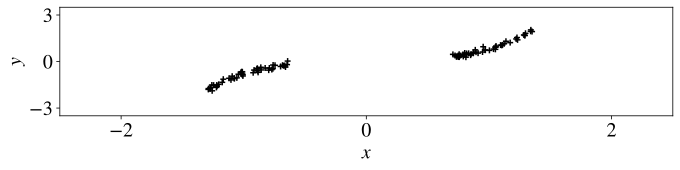

In [38]:
num_data = 100
num_input = 1
std_noise = 3.

x1 = tf.random.uniform(minval=-4., maxval=-2., shape=(num_data // 2, 1))
x2 = tf.random.uniform(minval=2., maxval=4., shape=(num_data // 2, 1))

x = tf.concat([x1, x2], axis=0)
y = tf.concat([x1, x2], axis=0) ** 3. + std_noise * tf.random.normal(shape=(num_data, 1))

x = (x - tf.reduce_mean(x)) / tf.math.reduce_std(x)
y = (y - tf.reduce_mean(y)) / tf.math.reduce_std(y)

# Figure to plot on 
plt.figure(figsize=(11, 2))

# Plot data
plt.scatter(
    x[:, 0],
    y[:, 0],
    marker="+",
    c="black"
)

# Format plot
plt.xlim([-2.5, 2.5])
plt.ylim([-3.5, 3.5])

plt.xticks(np.linspace(-2., 2., 3), fontsize=20)
plt.yticks(np.linspace(-3., 3., 3), fontsize=20)

plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)

plt.show()

Now we can train the model. We'll use a standard training procedure with Adam, and no special initialisation or scheduling tricks. We'll also train the model for quite a while to ensure it has converged.

In [68]:
# We decorate a single gradient descent step with tf.function. On the first
# call of single_step, tensorflow will compile the computational graph first.
# After that, all calls to single_step will use the compiled graph which is
# much faster than the default eager mode execution. In this case, the gain
# is roughly a x20 speedup (with a CPU), which can be checked by commenting
# out the decorator and rerunning the training script.

@tf.function
def single_step(model, optimiser, x, y):

    with tf.GradientTape() as tape:

        elbo, cond_lik, kl = model.elbo(x, y)
        loss = - elbo / x.shape[0]

    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))

    return elbo, cond_lik, kl

# Set model constants
num_input = 1
num_output = 1
num_inducing = 100
dtype = tf.float32
nonlinearity = "relu"
prior_scale_factor = 2.
num_steps = int(1e4)

# Initialise inducing points at subset of training points
inducing_idx = tf.random.shuffle(tf.range(x.shape[0]))[:num_inducing]
inducing_points = tf.gather(x, inducing_idx)

# Initialise model
model = GlobalInducingFullyConnectedNetwork(
    num_input=num_input,
    num_output=num_output,
    inducing_points=inducing_points,
    nonlinearity=nonlinearity,
    prior_scale_factor=prior_scale_factor,
    dtype=dtype
)

# Initialise optimiser
optimiser = tfk.optimizers.Adam(learning_rate=1e-2)
    
# Set progress bar and suppress warnings
progress_bar = tqdm(range(1, num_steps+1))
tf.get_logger().setLevel('ERROR')

# Set tensors for keeping track of quantities of interest
train_elbo = []
train_cond_lik = []
train_kl = []

# Train model
for i in progress_bar:
        
    elbo, cond_lik, kl = single_step(
        model=model,
        optimiser=optimiser,
        x=x,
        y=y
    )

    if i % 1000 == 0:
        
        progress_bar.set_description(
            f"ELBO {elbo:.1f}, "
            f"Cond-lik. {cond_lik:.1f}, "
            f"KL {kl:.1f}"
        )
        
    train_elbo.append(elbo)
    train_cond_lik.append(cond_lik)
    train_kl.append(kl)

We can verify that training has converged by looking at the ELBO. Training further will likely not improve the model parameters or inducing points.

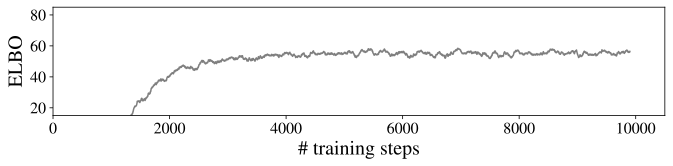

In [69]:
# Helper for computing moving average
def moving_average(array, n):
    
    cumsum = np.cumsum(array)
    cumsum[n:] = cumsum[n:] - cumsum[:-n]
    
    moving_average = cumsum[n - 1:] / n
    
    return moving_average

# Plot ELBO during optimisation
plt.figure(figsize=(11, 2))

plt.plot(
    moving_average(tf.stack(train_elbo).numpy(), n=100),
    color="black",
    alpha=0.5
)

# Format plot
plt.xlabel("# training steps", fontsize=20)
plt.ylabel("ELBO", fontsize=20)

plt.xticks(np.linspace(0, num_steps, 6), fontsize=16)

plt.yticks(np.linspace(20, 80, 4), fontsize=16)

plt.xlim([0, 1.05*num_steps])
plt.ylim([15., 85.])
plt.show()

Checking the plot below, we see that the model has fit the data well and produced reasonable uncertainty estimates. This is quite pleasing since we haven't had to use any tricks in the training procedure.

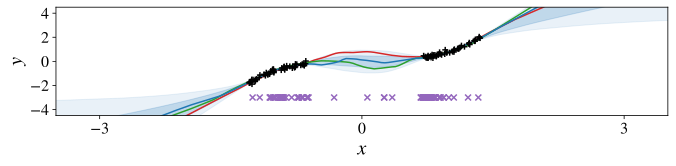

In [70]:
# Number of samples to draw, three will be plotted
num_samples = 100

# Input locations to plot
x_plot = tf.linspace(-4., 4., 200)[:, None]

# Draw samples from model
samples = [model(x_plot)[0] for i in range(num_samples)]

# Compute mean and standard deviation of samples
mean = tf.reduce_mean(samples, axis=0)
std = tf.math.reduce_std(samples, axis=0)

# Figure to plot on 
plt.figure(figsize=(11, 2))

# Plot epistemic uncertainty
plt.fill_between(
    x_plot[:, 0],
    mean[:, 0] - std[:, 0],
    mean[:, 0] + std[:, 0],
    color="tab:blue",
    alpha=0.2,
    zorder=1
)

plt.fill_between(
    x_plot[:, 0],
    mean[:, 0] - 2.*std[:, 0],
    mean[:, 0] + 2.*std[:, 0],
    color="tab:blue",
    alpha=0.1,
    zorder=1
)

# Plot three samples
for i, color in enumerate(["tab:red", "tab:green", "tab:blue"]):
    
    plt.plot(
        x_plot[:, 0],
        samples[i][:, 0],
        color=color,
        zorder=2
    )

# Plot data
plt.scatter(
    model.inducing_points[:, 0],
    -3.*tf.ones_like(model.inducing_points[:, 0]),
    marker="x",
    c="tab:purple",
    zorder=3
)

# Plot data
plt.scatter(
    x[:, 0],
    y[:, 0],
    marker="+",
    c="black",
    zorder=3
)

# Format plot
plt.xlim([-3.5, 3.5])
plt.ylim([-4.5, 4.5])

plt.xticks(np.linspace(-3., 3., 3), fontsize=16)
plt.yticks(np.linspace(-4., 4., 5), fontsize=16)

plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)

plt.show()

## How tight is the GIP ELBO?

We can also check how tight the ELBO of the GIP approximate posterior is, using importance sampling. We can estimate the same importance weighed lower bound of the marginal likelihood that importance weighed autoencoders {cite}`
burda2015importance` use. This importance weighted lower bound (IWBO) requires multiple samples from the approximate posterior. When using a single sample, the IWBO is identical to the ELBO, and as we increase the number of samples, the IWBO approaches the marginal likelihood. To get reliable estimates, we will evaluate the ELBO and the IWBO `num_repetitions = 10` times each. For the IWBO, we will use `num_iwbo_samples = 1000` samples for each estimate.

In [71]:
# Helper for computing the ELBO and IWBO
def evaluate_elbo_and_iwbo(model, num_repetitions, num_iwbo_samples):
    
    # Compute ELBO and IWBO num_repetitions times
    elbos = [
        model.elbo(x=x, y=y)[0] for i in range(num_repetitions)
    ]
    
    iwbos = [
        model.iwbo(x=x, y=y, num_samples=num_iwbo_samples) for i in range(num_repetitions)
    ]
    
    # Compute mean and error estimate for the mean, of the ELBO and IWBO
    elbo_mean = tf.reduce_mean(elbos)
    elbo_std = tf.math.reduce_std(elbos)/num_repetitions**0.5
    
    iwbo_mean = tf.reduce_mean(iwbos)
    iwbo_std = tf.math.reduce_std(iwbos)/num_repetitions**0.5
    
    return elbo_mean, elbo_std, iwbo_mean, iwbo_std


# Number of times to estimate the ELBO/IWBO
# and number of samples to draw for IWBO
num_repetitions = 10
num_iwbo_samples = 1000

# Compute mean and standard deviation for each
elbo_mean, elbo_std, iwbo_mean, iwbo_std = evaluate_elbo_and_iwbo(
    model=model,
    num_repetitions=num_repetitions,
    num_iwbo_samples=num_iwbo_samples
)

# Print results
print(
    f"ELBO: {elbo_mean: 7.3f} +/- {2.*elbo_std:.3f} "
    f"(estimated with {num_repetitions} ELBO samples)"
)

print(
    f"IWBO: {iwbo_mean: 7.3f} +/- {2.*iwbo_std:.3f} "
    f"(estimated with {num_repetitions} IWBO samples, "
    f"each using {num_iwbo_samples} weight samples)"
)

ELBO:  61.173 +/- 3.931 (estimated with 10 ELBO samples)
IWBO:  66.156 +/- 0.166 (estimated with 10 IWBO samples, each using 1000 weight samples)


We see that there is a statistically significant gap between the IWBO ($\approx$ marginal likelihood). However, considering there are $100$ datapoints in the dataset, the per-datapoint gap is relatively small. This suggests that the variational posterior is a good approximation to the true posterior. For a full comparison with existing approaches, it would be good to compare this with baselines such as mean-field VI{cite}`blundell2015weight` or other structured approximations. Recently, Thang Bui performed a more extensive comparison{cite}`bui2021biases` of various VI approximations for neural networks, and found that GIP produced ELBOs close to the marginal log-likelihood, as estimated by Annealed Importance Sampling.{cite}`neal2001annealed`

## More experiments

We next look at two factors which could affect the performance of GIP, the scale of the prior and the number of inducing points in the variational posterior. For convenience, we'll define a helper function, which will train a GIP BNN some parameters, which we'll then systematically sweep over.

In [72]:
def train_model(prior_scale_factor,
                num_inducing,
                learning_rate=1e-2,
                num_steps=int(1e5),
                num_eval_reps=10,
                num_iwbo_samples=10):

    @tf.function
    def single_step(model, optimiser, x, y):

        with tf.GradientTape() as tape:

            elbo, cond_lik, kl = model.elbo(x, y)
            loss = - elbo / x.shape[0]

        gradients = tape.gradient(loss, model.trainable_variables)
        optimiser.apply_gradients(zip(gradients, model.trainable_variables))

        return elbo, cond_lik, kl
    
    # Dictionary for holding experiment results
    results = {
        "train_elbo"     : [],
        "train_cond_lik" : [],
        "train_kl"       : [],
        "elbo_mean"      : None,
        "elbo_std"       : None,
        "iwbo_mean"      : None,
        "iwbo_std"       : None,
        "model"          : None
    }

    # Set model constants
    num_input = 1
    num_output = 1
    dtype = tf.float32
    nonlinearity = "relu"

    # Initialise inducing points at subset of training points
    inducing_idx = tf.random.shuffle(tf.range(x.shape[0]))[:num_inducing]
    inducing_points = tf.gather(x, inducing_idx)

    # Initialise model
    model = GlobalInducingFullyConnectedNetwork(
        num_input=num_input,
        num_output=num_output,
        inducing_points=inducing_points,
        nonlinearity=nonlinearity,
        prior_scale_factor=prior_scale_factor,
        dtype=dtype
    )

    # Initialise optimiser
    optimiser = tfk.optimizers.Adam(learning_rate=learning_rate)

    # Set progress bar and suppress warnings
    tf.get_logger().setLevel('ERROR')

    # Set tensors for keeping track of quantities of interest
    train_elbo = []
    train_cond_lik = []
    train_kl = []

    # Train model
    for i in range(num_steps):

        elbo, cond_lik, kl = single_step(
            model=model,
            optimiser=optimiser,
            x=x,
            y=y
        )

        results["train_elbo"].append(elbo)
        results["train_cond_lik"].append(cond_lik)
        results["train_kl"].append(kl)
        
    evaluation_results = evaluate_elbo_and_iwbo(
        model=model,
        num_repetitions=num_eval_reps,
        num_iwbo_samples=num_iwbo_samples
    )
    
    results["elbo_mean"] = evaluation_results[0]
    results["elbo_std"] = evaluation_results[1]
    results["iwbo_mean"] = evaluation_results[2]
    results["iwbo_std"] = evaluation_results[3]
    results["model"] = model
    
    return results

### Effect of prior scale

The choice of prior heavily affects any Bayesian model. In fact, and perhaps unsurprisingly, in preliminary tests the prior scale seemed to have a substantial effect on the quality of the fit.

In [18]:
num_prior_scales = 10
min_log10_prior_scale = -0.5
max_log10_prior_scale = 0.5
num_inducing = 100
learning_rate = 1e-2
num_steps = int(1e4)
num_eval_reps = 10
num_iwbo_samples = 1000

prior_scales = 10 ** np.linspace(
    min_log10_prior_scale,
    max_log10_prior_scale,
    num_prior_scales+1
)

# Set progress bar and suppress warnings
progress_bar = tqdm(list(enumerate(prior_scales)))

# List for holding all experimental results
prior_results = []

for i, prior_scale_factor in progress_bar:

    experiment_results = train_model(
        prior_scale_factor=prior_scale_factor,
        num_inducing=num_inducing,
        learning_rate=learning_rate,
        num_steps=num_steps,
        num_eval_reps=num_eval_reps,
        num_iwbo_samples=num_iwbo_samples
    )

    progress_bar.set_description(
        f"Experiment {i+1:02} Prior scale {prior_scale_factor:.3f}"
    )
    
    prior_results.append(experiment_results)

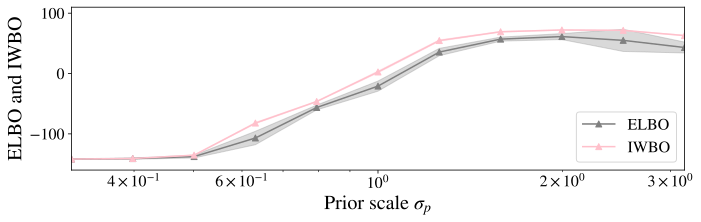

In [73]:
elbo_means = np.array([result["elbo_mean"] for result in prior_results])
elbo_stds = np.array([result["elbo_std"] for result in prior_results])

iwbo_means = np.array([result["iwbo_mean"] for result in prior_results])
iwbo_stds = np.array([result["iwbo_std"] for result in prior_results])

# Figure to plot on
plt.figure(figsize=(11, 3))

# Plot ELBO and error bars
plt.plot(
    prior_scales,
    elbo_means,
    color="grey",
    marker="^",
    label="ELBO"
)
plt.fill_between(
    prior_scales,
    elbo_means - 2.*elbo_stds,
    elbo_means + 2.*elbo_stds,
    color="grey",
    alpha=0.3
)

# Plot IWBO and error bars
plt.plot(
    prior_scales,
    iwbo_means,
    color="pink",
    marker="^",
    label="IWBO"
)

plt.fill_between(
    prior_scales,
    iwbo_means - 2.*iwbo_stds,
    iwbo_means + 2.*iwbo_stds,
    color="pink",
    alpha=0.3
)

# Format figure
plt.xscale("log")

plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)

plt.xlim([prior_scales[0], prior_scales[-1]])
plt.ylim([-160, 110])

plt.xlabel("Prior scale $\sigma_p$", fontsize=20)
plt.ylabel("ELBO and IWBO", fontsize=20)

plt.legend(loc="lower right", fontsize=16)

plt.show()

We see that the scale of the prior has a dramatic effect on the model performance. For small scales, the model performs very poorly. Plotting the fit for small prior scales shows that the model collapses to a constant or linear function and explains most, if not all, the variation in the data as noise. As the prior scale increases, the model performs much better, presumably because the prior no longer forces the weights close to zero. We also note that the gap between the ELBO and the IWBO remains relatively small throughout, reinforcing the conclusion that this approximate posterior is a good approximation of the true posterior.

### Effect of inducing points

Another interesting question is how the model performance depends on the number of inducing points. In variational approximations to GPs, the number of inducing points can heavily influence the quality of the approximation, and it would be no surprise if it did so here. However, the dependence of the approximate posterior and the predictive on the inducing points is less clear for GIP BNNs than it is for GPs. Here we vary the number of inducing points from a handful of points up to one inducing point per datapoint.

In [75]:
num_inducing_increment = 10
min_inducing_points = 10
max_inducing_points = 100
prior_scale_factor = 2.
learning_rate = 1e-2
num_steps = int(1e4)
num_eval_reps = 10
num_iwbo_samples = 1000

nums_inducing_points = np.arange(
    min_inducing_points,
    max_inducing_points+1,
    num_inducing_increment
)

nums_inducing_points = np.concatenate(
    [[1, 2, 5], nums_inducing_points]
)

# Set progress bar and suppress warnings
progress_bar = tqdm(list(enumerate(nums_inducing_points)))

# List for holding all experimental results
inducing_results = []

for i, num_inducing in progress_bar:

    experiment_results = train_model(
        prior_scale_factor=prior_scale_factor,
        num_inducing=num_inducing,
        learning_rate=learning_rate,
        num_steps=num_steps,
        num_eval_reps=num_eval_reps,
        num_iwbo_samples=num_iwbo_samples
    )

    progress_bar.set_description(
        f"Experiment {i+1:02} # inducing {num_inducing:.3f}"
    )
    
    inducing_results.append(experiment_results)

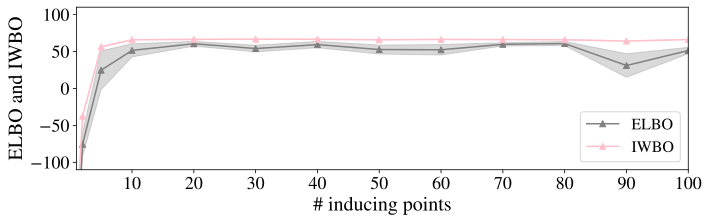

In [89]:
elbo_means = np.array([result["elbo_mean"] for result in inducing_results])
elbo_stds = np.array([result["elbo_std"] for result in inducing_results])

iwbo_means = np.array([result["iwbo_mean"] for result in inducing_results])
iwbo_stds = np.array([result["iwbo_std"] for result in inducing_results])

# Figure to plot on
plt.figure(figsize=(11, 3))

# Plot ELBO and error bars
plt.plot(
    nums_inducing_points,
    elbo_means,
    color="grey",
    marker="^",
    label="ELBO"
)

plt.fill_between(
    nums_inducing_points,
    elbo_means - 2.*elbo_stds,
    elbo_means + 2.*elbo_stds,
    color="grey",
    alpha=0.3
)

# Plot IWBO and error bars
plt.plot(
    nums_inducing_points, iwbo_means,
    color="pink",
    marker="^",
    label="IWBO"
)

plt.fill_between(
    nums_inducing_points, 
    iwbo_means - 2.*iwbo_stds, 
    iwbo_means + 2.*iwbo_stds,
    color="pink",
    alpha=0.3
)

# Format figure
plt.xlim([nums_inducing_points[0], nums_inducing_points[-1]])
plt.ylim([-110, 110])

plt.xticks(nums_inducing_points[3:], fontsize=18)
plt.yticks(np.linspace(-100, 100, 5), fontsize=18)

plt.xlabel("# inducing points", fontsize=20)
plt.ylabel("ELBO and IWBO", fontsize=20)

plt.legend(loc="lower right", fontsize=16)

plt.show()

With very few inducing points, the model does not perform well at all. As we increase the number of inducing points, the model performance increases accordingly, until it reaches a plateau, after which it does not improve further.

## Conclusion

## References

```{bibliography} ./references.bib
```